**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```
**Data Source**
*   Clean data to perform model training can be downloaded from here: [datasets.zip](https://drive.google.com/file/d/1xMF-lupg9UX-UZUD6NlC2h-Ao08gQ6f3/view?usp=sharing)

* Original data can be downloaded from here: [train](https://storage.googleapis.com/ibeans/train.zip) - [validation](https://storage.googleapis.com/ibeans/validation.zip) - [test](https://storage.googleapis.com/ibeans/test.zip)

* Original data description: https://github.com/AI-Lab-Makerere/ibean/
------------------------------
**Summary**

The current notebook contains the hyperparameter search for the previously found architectures.   
The main [outcomes](#scrollTo=xgSB_k1Bz26x) are summed up in the last section of the current notebook.

------------------------------

# Installing Keras Tuner

In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 6.7 MB/s eta 0:00:00


# Importing Libraries

In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras import backend as K
from google.colab import drive
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.experimental import SGD
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Load Image Datasets in Size 128, 128

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_size = (128, 128)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42

In [4]:
ds_train = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/train",
                                        labels=labels,
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed
                                        )

ds_validation = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/validation",
                                             labels=labels,
                                             image_size=image_size,
                                             crop_to_aspect_ratio=crop_to_aspect_ratio,
                                             color_mode=color_mode,
                                             batch_size=batch_size,
                                             label_mode=label_mode,
                                             shuffle=shuffle,
                                             seed=seed
                                             )

ds_test = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/test",
                                       labels=labels, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,
                                       shuffle=shuffle,
                                       seed=seed
                                       )

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [5]:
input_shape1 = tuple(iter(ds_train).next()[0].shape[1:])

In [6]:
input_shape1

(128, 128, 3)

# Load Image Datasets in Size 256, 256

In [7]:
image_size256 = (256, 256)

In [8]:
ds_train256 = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/train",
                                        labels=labels,
                                        image_size=image_size256,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed
                                        )

ds_validation256 = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/validation",
                                             labels=labels,
                                             image_size=image_size256,
                                             crop_to_aspect_ratio=crop_to_aspect_ratio,
                                             color_mode=color_mode,
                                             batch_size=batch_size,
                                             label_mode=label_mode,
                                             shuffle=shuffle,
                                             seed=seed
                                             )

ds_test256 = image_dataset_from_directory("/content/drive/MyDrive/Uni/DL/Project/datasets/datasets/test",
                                       labels=labels, 
                                       image_size=image_size256,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,
                                       shuffle=shuffle,
                                       seed=seed
                                       )

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [9]:
input_shape2 = tuple(iter(ds_train256).next()[0].shape[1:])

In [10]:
input_shape2

(256, 256, 3)

# Create Agumentation Layer

In [11]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

----------------------------------------------

# Hyperparameter Search LeNet

In [12]:
def LeNet_builder(hp):
    cnn = Sequential([layers.Input((256, 256, 3)),                                  
                      # Data augmentation
                      augmentation,
                      # Data preprocessing
                      layers.Rescaling(1./255),
                      # 1st convLayer
                      layers.Conv2D(
                          filters=hp.Int('conv_1_num_filters', min_value=8, max_value=128, step=8),
                          kernel_size=hp.Choice('conv_1_kernel_size', values = [2,3,4,5,6,7,8]),
                          kernel_initializer=initializers.GlorotNormal(seed=42)
                          ),
                      layers.Activation(hp.Choice('1_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('1_pool_size', values = [2,3,4])),
                      # 2nd convLayer
                      layers.Conv2D(
                          filters=hp.Int('conv_2_num_filters', min_value=16, max_value=128, step=8),
                          kernel_size=hp.Choice('conv_2_kernel_size', values = [2,3,4,5,6,7,8]),
                          kernel_initializer=initializers.GlorotNormal(seed=42)
                          ),
                      layers.Activation(hp.Choice('2_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('2_pool_size', values = [2,3,4])),
                      # From a HxWxC cuboid to a (H*W*C) vector per image
                      layers.Flatten(),
                      # Classification 
                      layers.Dense(
                          units=3,
                          activation=hp.Choice('dense_activation', values=['relu', 'softmax', 'sigmoid']),
                          kernel_initializer=initializers.GlorotNormal(seed=42)
                          )
                      ], 
                  name="CNN-1"
                  )

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn.compile(loss="categorical_crossentropy",
    optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),  
    metrics=[
            metrics.CategoricalAccuracy(name='categorical_accuracy'),
            metrics.AUC(name='AUROC')
          ]
      )
    
    K.set_value(cnn.optimizer.learning_rate, hp_learning_rate)

    return cnn

# Hyperparameter Search AlexNet

In [13]:
def AlexnNet_builder(hp):
    cnn = Sequential([layers.Input((128,128,3)),                                          
                      # Data augmentation
                      augmentation,     
                      # Feature extraction
                      layers.BatchNormalization(),  
                      # P1
                      layers.Conv2D(filters=hp.Int('conv_1_num_filters', min_value=32, max_value=128, step=8),
                                    kernel_size=hp.Choice('conv_1_kernel_size', values = [4,5,6,7,8,9,10,11,12]),
                                    strides=hp.Choice('conv_1_strides', values = [3,4,5]),  
                                    kernel_initializer=initializers.GlorotNormal(seed=42)
                                    ),
                      layers.BatchNormalization(),  
                      layers.Activation(hp.Choice('1_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('1_pool_size', values = [2,3,4]),
                                          strides=hp.Choice('1_strides', values = [1,2,3])
                                          ),
                      # P2
                      layers.Conv2D(filters=hp.Int('conv_2_num_filters', min_value=128, max_value=256, step=8),
                                    kernel_size=hp.Choice('conv_2_kernel_size', values = [3,4,5,6,7]),
                                    padding=hp.Choice('conv_2_padding', values=['same']),
                                    kernel_initializer=initializers.GlorotNormal(seed=42)
                                    ),
                      layers.Activation(hp.Choice('2_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('2_pool_size', values = [2,3,4]),
                                          strides=hp.Choice('1_strides', values = [1,2,3])
                                          ),
                      # P3
                      layers.Conv2D(filters=hp.Int('conv_3_num_filters', min_value=128, max_value=256, step=8),
                                    kernel_size=hp.Choice('conv_3_kernel_size', values = [2,3,4,5]),
                                    padding=hp.Choice('conv_3_padding', values=['same']),
                                    kernel_initializer=initializers.GlorotNormal(seed=42)
                                    ),
                      layers.Activation(hp.Choice('3_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('3_pool_size', values = [2,3,4]),
                                          strides=hp.Choice('3_strides', values = [1,2,3])
                                          ),
                      # From a HxWxC cuboid to a (C) vector per image
                      layers.GlobalAveragePooling2D(),
                      # Classification 
                      layers.Dropout(hp.Choice('dropout', values = [0.2,0.3,0.4])),     
                      layers.Dense(units=3,
                                  activation=hp.Choice('dense_activation', values=['relu', 'softmax', 'sigmoid']),
                                  kernel_regularizer = regularizers.L2(l2=hp.Choice('dropout', values = [0.001, 0.0001, 0.00001])),
                                  bias_regularizer = regularizers.L2(hp.Choice('dropout', values = [0.001, 0.0001, 0.00001])),
                                  kernel_initializer=initializers.GlorotNormal(seed=42)
                                  )
                      ],
                      name="CNN-2"
                      )

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn.compile(loss="categorical_crossentropy",
    optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),  
    metrics=[
            metrics.CategoricalAccuracy(name='categorical_accuracy'),
            metrics.AUC(name='AUROC')
          ]
      )
    
    K.set_value(cnn.optimizer.learning_rate, hp_learning_rate)
    

    return cnn

# Hyperparameter Search Custom Architecture

In [64]:
def Custom_builder(hp):
    cnn = Sequential([# The input layer
                      layers.Input((256,256,3)),
                      # Data augmentation
                      augmentation,     
                      # Feature extraction
                      layers.BatchNormalization(),
                      layers.Conv2D(filters=hp.Int('conv_1_num_filters', min_value=32, max_value=128, step=8),
                                    kernel_size=hp.Choice('conv_1_kernel_size', values = [4,5,6,7,8,9,10,11,12]),
                                    strides=hp.Choice('conv_1_strides', values = [3,4,5]),  
                                    kernel_initializer=initializers.GlorotNormal(seed=42)
                                    ),
                      layers.BatchNormalization(),
                      layers.Activation(hp.Choice('1_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('1_pool_size', values = [2,3,4]),
                                           strides=hp.Choice('1_strides', values = [1,2,3])
                                           ),
                      layers.Conv2D(filters=hp.Int('conv_2_num_filters', min_value=128, max_value=256, step=8),
                                    kernel_size=hp.Choice('conv_2_kernel_size', values = [3,4,5,6,7]),
                                    padding=hp.Choice('conv_2_padding', values=['same']),
                                    kernel_initializer=initializers.GlorotNormal(seed=42)
                                    ),
                      layers.BatchNormalization(),
                      layers.Activation(hp.Choice('2_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('2_pool_size', values = [2,3,4]),
                                          strides=hp.Choice('2_strides', values = [1,2,3])
                                          ),
                      layers.Conv2D(filters=hp.Int('conv_3_num_filters', min_value=128, max_value=256, step=8),
                                    kernel_size=hp.Choice('conv_3_kernel_size', values = [3,4,5,6,7]),
                                    padding=hp.Choice('conv_3_padding', values=['same']),
                                    kernel_initializer=initializers.GlorotNormal(seed=42)
                                    ),
                      layers.BatchNormalization(),
                      layers.Activation(hp.Choice('3_activation', values=['relu', 'softmax', 'sigmoid'])),
                      layers.MaxPooling2D(pool_size=hp.Choice('3_pool_size', values = [2,3,4]),
                                          strides=hp.Choice('3_strides', values = [1,2,3])
                                          ),
                      layers.GlobalMaxPooling2D(),
                      layers.Dropout(hp.Choice('dropout', values = [0.2,0.3,0.4])),
                      # Classification
                      layers.Dense(
                           units=3,
                           activation=hp.Choice('dense_activation', values=['relu', 'softmax', 'sigmoid']),
                           kernel_initializer=initializers.GlorotNormal(seed=42)
                           )
                      ],
                     name="CNN-2"
                     )

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    cnn.compile(loss="categorical_crossentropy",
    optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),  
    metrics=[
            metrics.CategoricalAccuracy(name='categorical_accuracy'),
            metrics.AUC(name='AUROC')
          ]
      )
    
    K.set_value(cnn.optimizer.learning_rate, hp_learning_rate)

    return cnn

In [65]:
tuner = kt.Hyperband(
    Custom_builder,
    objective='val_categorical_accuracy',
    max_epochs=100,
    factor=3,
    directory='Custom_256',
    project_name='Custom_256',
    overwrite=True)

In [66]:
stop_early = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

In [67]:
tuner.search(ds_train256, validation_data=ds_validation256, epochs=100, callbacks=[stop_early])

Trial 3 Complete [00h 00m 09s]
val_categorical_accuracy: 0.36090224981307983

Best val_categorical_accuracy So Far: 0.36090224981307983
Total elapsed time: 00h 00m 27s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
64                |40                |conv_1_num_filters
8                 |11                |conv_1_kernel_size
3                 |5                 |conv_1_strides
relu              |sigmoid           |1_activation
4                 |2                 |1_pool_size
3                 |1                 |1_strides
144               |128               |conv_2_num_filters
7                 |7                 |conv_2_kernel_size
same              |same              |conv_2_padding
sigmoid           |relu              |2_activation
2                 |2                 |2_pool_size
3                 |1                 |2_strides
144               |208               |conv_3_num_filters
3                 |6                 |conv_3_kernel_size
same  

KeyboardInterrupt: ignored

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(ds_train256, epochs=100, validation_data=ds_validation256, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_categorical_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
best_hps.values

In [ ]:
best_epoch

In [ ]:
stop_early_final = EarlyStopping(monitor='val_categorical_accuracy', patience=15)

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(ds_train256, epochs=100, validation_data=ds_validation256, callbacks=[stop_early_final])


In [ ]:
df_hist = pd.DataFrame.from_dict(history.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["categorical_accuracy", "val_categorical_accuracy", "AUROC", "val_AUROC"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves", 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                         alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Categorical Accuracy")
ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
ax.right_ax.set_ylim(0.45, 1.05)
ax.legend(loc=(1.15, 0.40), framealpha=1.0)
plt.show()

In [ ]:
eval_result = hypermodel.evaluate(ds_test256)
print("[test loss, categorical_accuracy, test accuracy]:", eval_result)

In [ ]:
hypermodel.summary()

In [61]:
%cd /content/drive/MyDrive
%mkdir -p saved_model
hypermodel.save('saved_model/Custom_256_2')

/content/drive/MyDrive


In [62]:
loaded_model = load_model("saved_model/Custom_256_2")

In [63]:
eval_result_loaded = loaded_model.evaluate(ds_test256)
print("[test loss, categorical_accuracy, test accuracy]:", eval_result_loaded)

8/8 [==============================] - 0s 8ms/step - loss: 0.4842 - categorical_accuracy: 0.8359 - AUROC: 0.9497
[test loss, categorical_accuracy, test accuracy]: [0.48417481780052185, 0.8359375, 0.9497222900390625]


# Outcomes

### LeNet Architecture with (128, 128)
```
image_size = (128, 128)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42
```
The HPS gave us: 
```
{'conv_1_num_filters': 16,
 'conv_1_kernel_size': 6,
 '1_activation': 'relu',
 '1_pool_size': 2,
 'conv_2_num_filters': 56,
 'conv_2_kernel_size': 6,
 '2_activation': 'relu',
 '2_pool_size': 4,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.0001,
 'optimizer': 'rmsprop',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0206'}
```

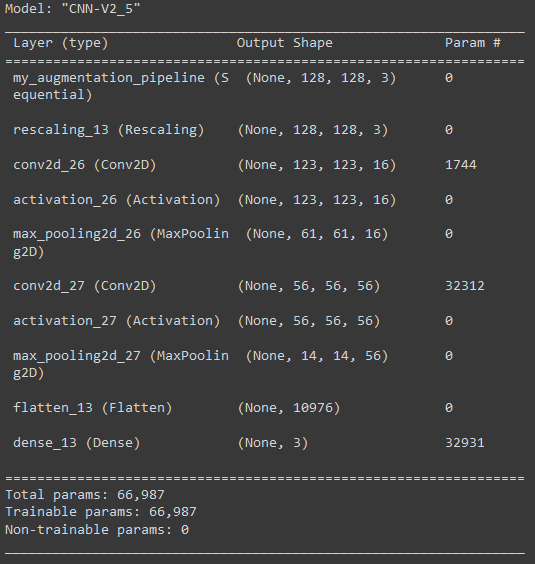

#### Training Curve LeNet (To Change: New Graph Design)
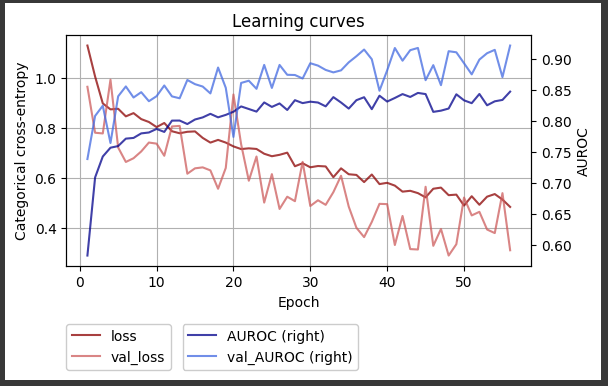

#### LeNet evaluation on test dataset

```
[test loss, categorical_accuracy, test accuracy]: [0.3569413125514984, 0.875, 0.91448974609375]
```



---
---



### LeNet Architecture with (256, 256)
```
image_size256 = (256, 256)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42
```
The HPS gave us: 
```
{'conv_1_num_filters': 128,
 'conv_1_kernel_size': 7,
 '1_activation': 'relu',
 '1_pool_size': 4,
 'conv_2_num_filters': 128,
 'conv_2_kernel_size': 8,
 '2_activation': 'relu',
 '2_pool_size': 4,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.001,
 'optimizer': 'sgd',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 4,
 'tuner/round': 4,
 'tuner/trial_id': '0142'}
```
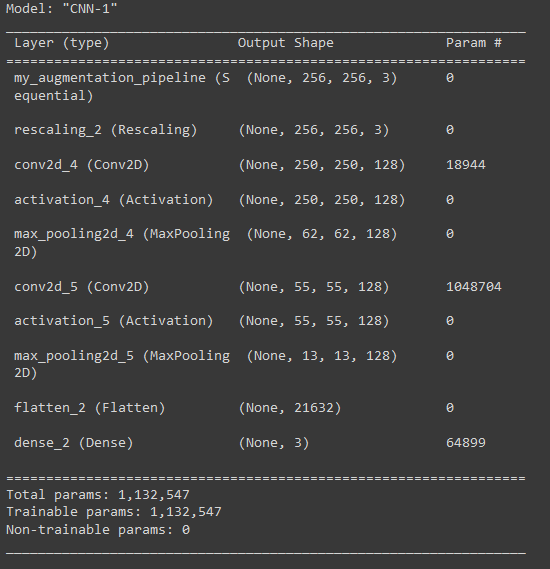


#### Training Curve LeNet
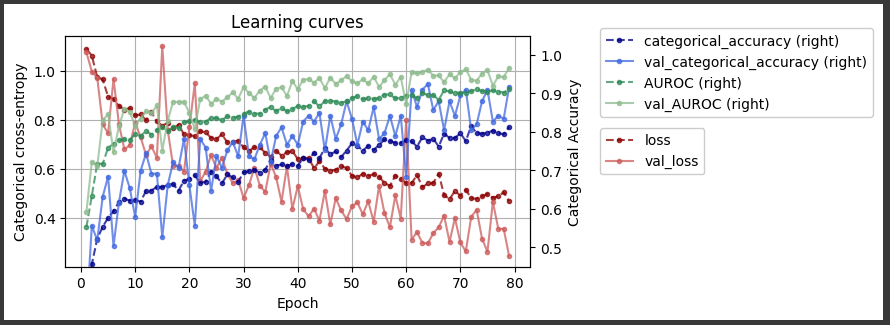

#### LeNet evaluation on test dataset

```
[test loss, categorical_accuracy, test accuracy]: [0.40438395738601685, 0.859375, 0.935699462890625]
```

---
---

### AlexNet Architecture with (128, 128)
```
image_size256 = (128, 128)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42
```
The HPS gave us: 
```
{'conv_1_num_filters': 96,
 'conv_1_kernel_size': 9,
 'conv_1_strides': 5,
 '1_activation': 'relu',
 '1_pool_size': 3,
 '1_strides': 2,
 'conv_2_num_filters': 232,
 'conv_2_kernel_size': 7,
 'conv_2_padding': 'same',
 '2_activation': 'sigmoid',
 '2_pool_size': 2,
 'conv_3_num_filters': 232,
 'conv_3_kernel_size': 3,
 'conv_3_padding': 'same',
 '3_activation': 'relu',
 '3_pool_size': 3,
 '3_strides': 3,
 'dropout': 0.4,
 'dense_activation': 'softmax',
 'learning_rate': 0.0001,
 'optimizer': 'adam',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0210'}
```

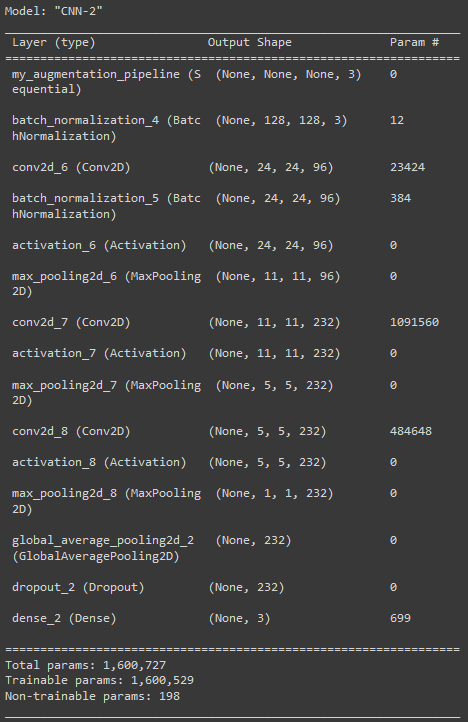

#### Training Curve AlexNet
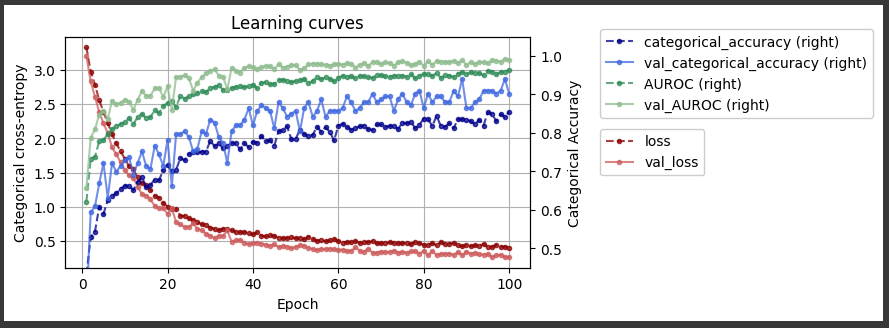

#### AlexNet evaluation on test dataset




```
[test loss, categorical_accuracy, test accuracy]: [0.3871889114379883, 0.8828125, 0.9662628173828125]
```

---
---

### AlexNet Architecture with (256, 256)
```
image_size256 = (256, 256)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42
```
The HPS gave us: 
```
{'conv_1_num_filters': 48,
 'conv_1_kernel_size': 11,
 'conv_1_strides': 3,
 '1_activation': 'sigmoid',
 '1_pool_size': 4,
 '1_strides': 3,
 'conv_2_num_filters': 160,
 'conv_2_kernel_size': 4,
 'conv_2_padding': 'valid',
 '2_activation': 'relu',
 '2_pool_size': 2,
 'conv_3_num_filters': 240,
 'conv_3_kernel_size': 2,
 'conv_3_padding': 'same',
 '3_activation': 'relu',
 '3_pool_size': 4,
 '3_strides': 1,
 'dropout': 0.2,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.001,
 'optimizer': 'rmsprop',
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0191'}
```
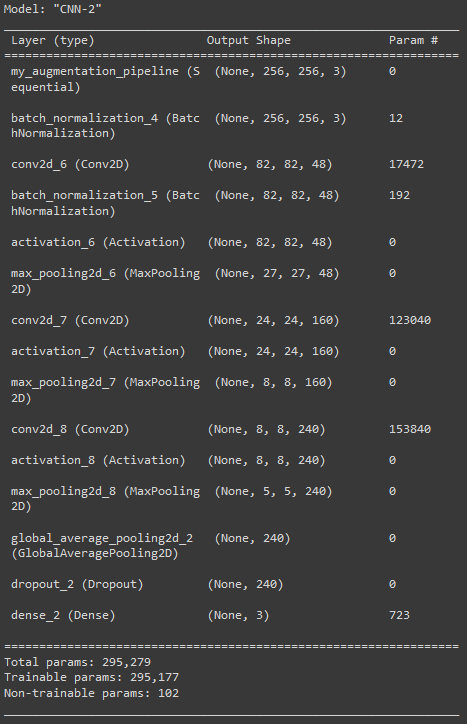

#### Training Curve AlexNet

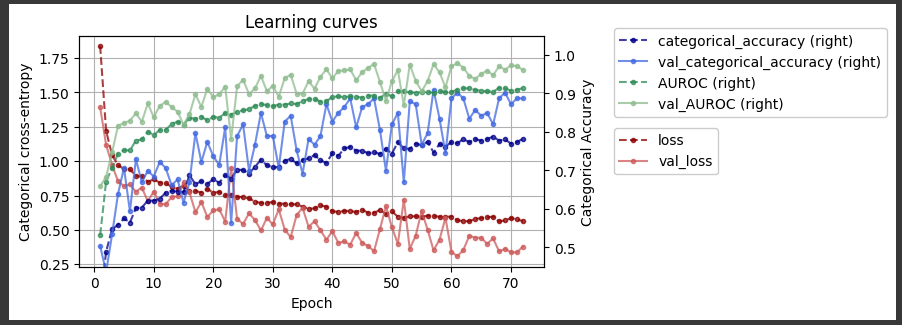

#### AlexNet evaluation on test dataset



```
[test loss, categorical_accuracy, test accuracy]: [0.5259636640548706, 0.7890625, 0.923492431640625]
```





---

---



### Custom Architecture with (128, 128)


```
image_size = (128, 128)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42

```
The HPS gave us:



```
{'conv_1_num_filters': 120,
 'conv_1_kernel_size': 6,
 'conv_1_strides': 4,
 '1_activation': 'softmax',
 '1_pool_size': 3,
 '1_strides': 2,
 'conv_2_num_filters': 248,
 'conv_2_kernel_size': 4,
 'conv_2_padding': 'same',
 '2_activation': 'softmax',
 '2_pool_size': 3,
 '2_strides': 2,
 'conv_3_num_filters': 248,
 'conv_3_kernel_size': 4,
 'conv_3_padding': 'same',
 '3_activation': 'softmax',
 '3_pool_size': 3,
 '3_strides': 2,
 'dropout': 0.3,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.01,
 'optimizer': 'rmsprop',
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0173'}
```
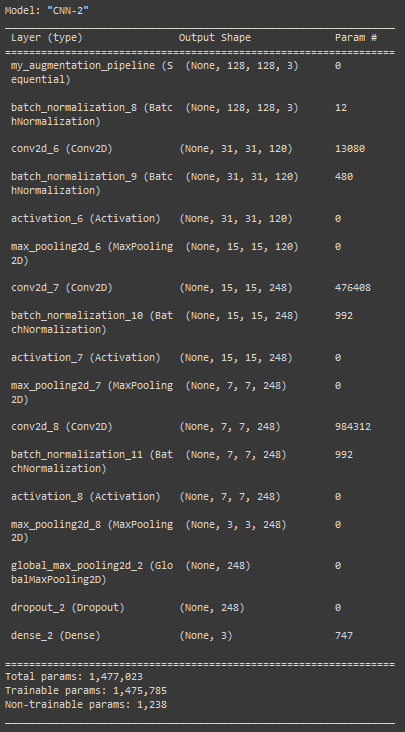



#### Training Curve Custom Architecture
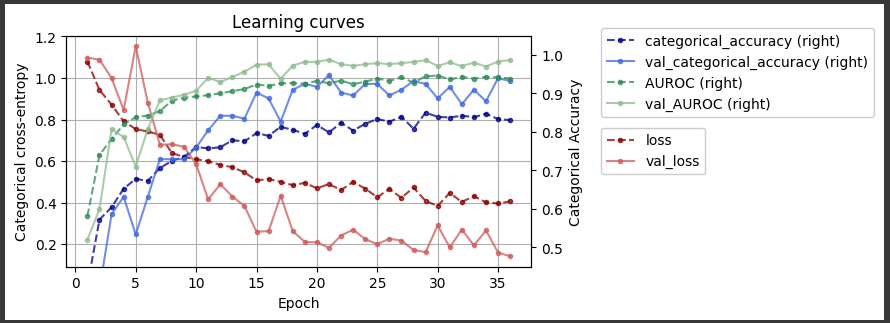

#### Custom Architecture evaluation on test dataset




```
[test loss, categorical_accuracy, test accuracy]: [0.23079217970371246, 0.8984375, 0.975555419921875]
```



### Custom Architecture with (256, 256)

```
image_size = (256, 256)
crop_to_aspect_ratio = False
labels='inferred'
color_mode="rgb"
batch_size=16
label_mode="categorical"
shuffle=True
seed=42

```
The HPS gave us:



```
{'conv_1_num_filters': 80,
 'conv_1_kernel_size': 11,
 'conv_1_strides': 3,
 '1_activation': 'relu',
 '1_pool_size': 4,
 '1_strides': 3,
 'conv_2_num_filters': 192,
 'conv_2_kernel_size': 5,
 'conv_2_padding': 'same',
 '2_activation': 'relu',
 '2_pool_size': 4,
 '2_strides': 3,
 'conv_3_num_filters': 192,
 'conv_3_kernel_size': 5,
 'conv_3_padding': 'same',
 '3_activation': 'relu',
 '3_pool_size': 4,
 '3_strides': 3,
 'dropout': 0.3,
 'dense_activation': 'softmax',
 'learning_rate': 0.01,
 'optimizer': 'adam',
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 4,
 'tuner/round': 3,
 'tuner/trial_id': '0139'}
```
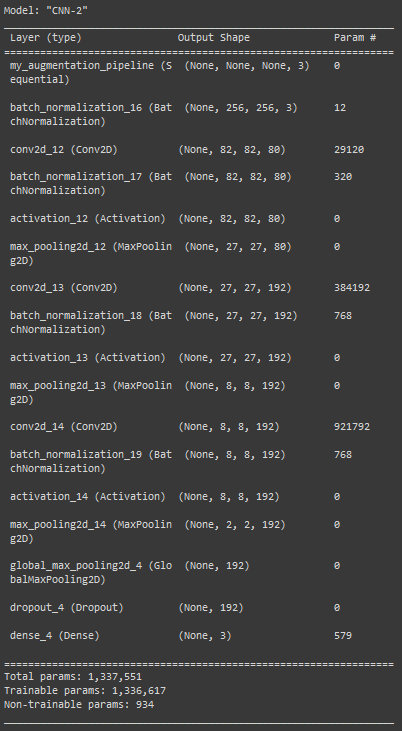

#### Training Curve Custom Architecture
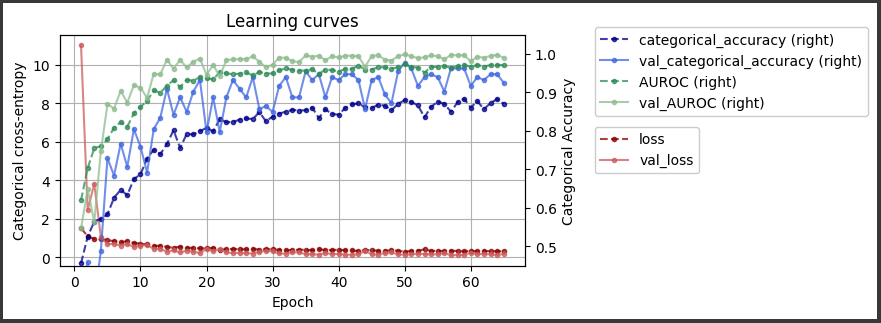

#### Custom Architecture evaluation on test dataset



```
[test loss, categorical_accuracy, test accuracy]: [0.48417481780052185, 0.8359375, 0.9497222900390625]

```



## Conclusion

| Model | Accuracy on Test Dataset |
| --- | --- |
| LeNet(128,128,3)  |  0.8750 |
| AlexNet(128,128,3) |  0.8828 |
| **Custom (128,128,3**) |  **0.8984** |
| LeNet(256,256,3) | 0.8594|
| AlexNet(256,256,3) |  0.7891 |
| Custom(256,256,3) |  0.8359 |

All of the networks perform better with images in size (128,128,3). The Custom Architecture had the best categorical accuracy (89.84%) on the test dataset. None of the modles is overfitting, the validation accuracy is higher than the train accuracy for all of them, but they are not able to score with a simmilar validation accuracy when evaluated against the test set.